In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
%matplotlib inline
import math
import fitClus2D as fc
from scipy.stats import sigmaclip
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

import astropy
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.wcs import WCS
from astropy.cosmology import FlatLambdaCDM

from PIL import Image

# These cuts get you a 4x4 arcmin square centered on the image center of the fields
img_cuts = {'a2744':[[519,4520],[412,4413]],
            'm0416':[[367,4368],[380,4381]]}
img_files = {'a2744':'Files/abell2744_RGB.fits',
             'm0416':'Files/macs0416_RGB.fits'}

zclus = {'a2744' : 0.308,
         'm0416' : 0.396}
pgals = {'a2744' : [1.689791e-01, 1.965115e+00, 2.0],
        'm0416' : [3.737113e-01, 1.322081e+00, 2.0]}


In [2]:
cluster = 'a2744'
catalog = "Files/" + cluster + "_master_cleaned.csv"

#Set up clusters, not clusters, and unknowns
dzcut=0.03; sigclip=3; sigcut=3; radialcut=120; maglim=23.5; colorcut=1.0
master = pd.read_csv(catalog)
zdat = master['master_z']
valid = master['master_valid']
memberindx = np.where((zdat>zclus[cluster]-dzcut)&(zdat<zclus[cluster]+dzcut)&(valid==1))[0]
z1 = zdat[memberindx]
z2 = sigma_clip(z1,sigma=sigclip)
print(np.mean(z2),np.std(z2))

dz = sigcut*np.std(z2)
print(dz)
ddat = master['master_d']
zdat = master['master_z']
mag814 = master['master_mag814']
mag606 = master['master_mag606']
valid = master['master_valid']
master_cut = master.iloc[np.where((ddat<radialcut)&(~np.isnan(mag606))&(~np.isnan(mag814))&(mag814<=maglim)&(valid == 1))]

zdat   = master_cut['master_z']
nmemindx = np.where((zdat<zclus[cluster]-dz)|(zdat>zclus[cluster]+dz))[0]
memindx = np.where((zdat>zclus[cluster]-dz)&(zdat<zclus[cluster]+dz))[0]
unknownindx = np.where(np.isnan(zdat))[0]

clusterarr = [master_cut.iloc[i] for i in memindx]
ncluster =[master_cut.iloc[i] for i in nmemindx]
unknown = [master_cut.iloc[i] for i in unknownindx]

XclustCM= [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in clusterarr]
XnclustCM = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in ncluster]
Xcm = np.array(XclustCM + XnclustCM)

Xclustall= [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_d']] for row in clusterarr]
Xnclustall = [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_d']] for row in ncluster]
Xall = np.array(Xclustall + Xnclustall)

unknownXcm = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in unknown]
unknownXcm = np.array(unknownXcm)

y = np.zeros(len(clusterarr) + len(ncluster))
y[:len(clusterarr)] = 1

clustnum = len(clusterarr)
nclustnum = len(ncluster)
print(len(memindx))
print(len(nmemindx))
print(len(unknownindx))


0.3069860850098326 0.007357462290748165
0.022072386872244495
92
46
235


In [100]:
# Read in RGB file 
RGB = fits.open(img_files[cluster])

# Put separate extensions into own R/G/B arrays
imr=Image.fromarray(RGB[1].data,mode=None) 
img=Image.fromarray(RGB[2].data,mode=None)
imb=Image.fromarray(RGB[3].data,mode=None)

# Merge them back into one image
merged=Image.merge("RGB",(imr,img,imb))

# Conversion factor to translate between x & y and pixels
# In units of arcseconds per pixel
conv = 23.8809/398.015 

# Cut image down to square shape & zoom in since it's a little big
xx = img_cuts[cluster][0] # sets area to cut to
yy = img_cuts[cluster][1]
val = 0 # sets zoom in

imgcut = np.array(merged)[xx[0]+val:xx[1]-val,yy[0]+val:yy[1]-val]

In [3]:
#Set up images
cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.3)
img = fc.imgclass("Files/" + cluster + "_images.dat", zclus[cluster], cosmo)

Read image data from file Files/a2744_images.dat


In [4]:
#Ways to assign probabilities
def normalize(X, p):
    copyX = np.copy(X)
    copyp = np.copy(p)
    for i in range((len(X[0]))):
        mn = np.min(X[:,i])
        mx = np.max(X[:,i])
        copyX[:,i] = (X[:,i] - mn) / (mx - mn)
        copyp[:,i] = (p[:,i] - mn) / (mx - mn)
    
    return copyX, copyp
    
def Knn(X, y, p, k):
    normX, normp = normalize(X, p)
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(normX, y)
    return model.predict_proba(normp)[:,1], model.predict(normp)

def Rnn(X, y, p, r):
    normX, normp = normalize(X, p)
    model = RadiusNeighborsClassifier(radius = r, outlier_label = 0)
    model.fit(normX, y)
    return model.predict_proba(normp)[:,1], model.predict(normp)

def box(X, y, p, numx, numy):
    minm = np.min(Xcm[:,0])
    maxm = np.max(Xcm[:,0])
    minc = np.min(Xcm[:,1])
    maxc = np.max(Xcm[:,1])
    w = maxm - minm
    h = maxc - minc
    minm -= 0.01 * w
    maxm += 0.01 * w
    minc -= 0.01 * h
    maxc += 0.01 * h
    
    boxw = (maxm - minm) / numx
    boxh = (maxc - minc) / numy
    grid = np.zeros((numx, numy, 2))
    
    for i, point in enumerate(X):
        xcoor = int((point[0] - minm) / boxw)
        ycoor = int((point[1] - minc) / boxh)
        grid[xcoor, ycoor, 1] += 1
        grid[xcoor, ycoor, 0] += y[i]
        
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    
    for i, point in enumerate(p):
        if point[0] >= minm and point[0] < maxm and point[1] >= minc and point[1] <= maxc:
            xcoor = int((point[0] - minm) / boxw)
            ycoor = int((point[1] - minc) / boxh)
            if not grid[xcoor, ycoor, 1] == 0:
                probs[i] = grid[xcoor, ycoor, 0] / grid[xcoor, ycoor, 1]
                if probs[i] > 0.5: classes[i] = 1
                    
    return probs, classes

def sigmaCut(X, y, p, k):
    clustermag = [dat[0] for i, dat in enumerate(X) if y[i] == 1]
    clustercolor = [dat[1] for i, dat in enumerate(X) if y[i] == 1]
    
    model = np.polyfit(clustermag, clustercolor, 1)
    predict = np.poly1d(model)
    
    res = clustercolor - predict(clustermag)
    sigma = np.std(res)
    
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    
    nclust = 0
    ntot = 0
    
    for i, point in enumerate(X):
        if abs(point[1] - predict(point[0])) < k * sigma:
            if y[i] == 1:
                nclust += 1
            ntot += 1
    prob = nclust / ntot
    
    for i, point in enumerate(p):
        if abs(point[1] - predict(point[0])) < k * sigma:
               probs[i] = prob
               classes[i] = 1
    return probs, classes


In [5]:
clusterData = [[row['master_x'], row['master_y'], row['master_mag814'], 1] for row in clusterarr]
unknownData = [[row['master_x'], row['master_y'], row['master_mag814'], 0] for row in unknown]
data = np.array(clusterData + unknownData)


    
#draw scatter plot of uncertainties in varying cluster members, or in scattering
def scatterDraw(n, scatter, ax, probs = [], color = "red"):
    global data
    colors = ["red", "blue", "green"]
    data[clustnum:,3] = probs
    
    gal = fc.galclass(data)
    gal.scale()
    alldeflect = []
    
    for i in range(n):
        gal.draw(scatter)
        deflect, gamma = gal.calcdefbasic(images)
        alldeflect.append(deflect)

    alldeflect = np.array(alldeflect)
    for i in range(len(images)):
        x = alldeflect[:,i,0]
        y = alldeflect[:,i,1]
        ax.scatter(x, y, color = color, alpha = 0.5)
    
    return np.mean(alldeflect, axis = 0)


In [6]:
#Get probability arrays
knnprob = Knn(Xcm, y, unknownXcm, 12)[0]
rnnprob = Rnn(Xcm, y, unknownXcm, 0.25)[0]
boxprob = box(Xcm, y, unknownXcm, 3, 5)[0]
sigmaclass = sigmaCut(Xcm, y, unknownXcm, 1.0)[1]

Read in 327 galaxies
Read in 327 galaxies


KeyboardInterrupt: 

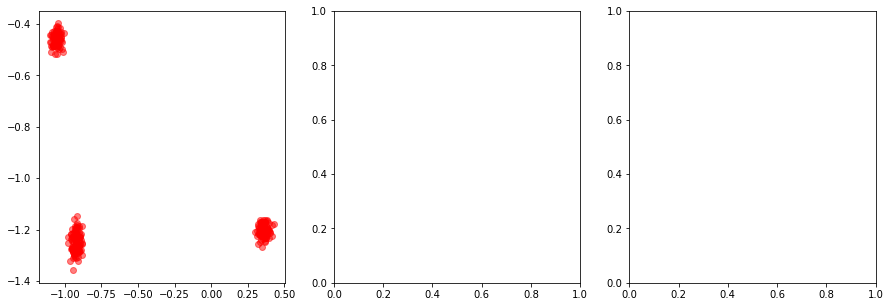

In [9]:
images = np.array([[-28.5912, -24.0012], [-23.6743, -34.4608], [6.5976, -45.8501]])
fig,((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5))

scatterDraw(100, True, ax1, sigmaclass)
scatterDraw(100, True, ax2, sigmaclass)
scatterDraw(100, True, ax3, sigmaclass)

scatterDraw(100, True, ax1, knnprob, "blue")
scatterDraw(100, True, ax2, rnnprob, "blue")
scatterDraw(100, True, ax3, boxprob, "blue")
ax1.set_title("K nearest neighbors")
ax2.set_title("Radius nearest neighbors")
ax3.set_title("Boxes")

In [115]:
def getStats(n, probs, scatter, b0, img = img):
    global data
    data[clustnum:,3] = probs
    ind = -1
    mn = 100
    for i, dat in enumerate(data):
        if dat[3] == 1 and dat[2] < mn:
            ind = i
            mn = dat[2]
    
    print(ind)
    gal = fc.galclass(data, logflags = [True, True])
    gal.scale(ref = [ind])

    deflects = fc.defclass()
    deflects.draw(gal, img, b0, [1.0], n, scatter = scatter, useD = True)
    return deflects.marr, deflects.Garr, deflects.Cmat

def scatterMeans(n, probs, scatter, ax, color):
    marr = getStats(n, probs, scatter)[0]
    ax.scatter(marr[0,:,0], marr[0,:,1], color = color)
    return marr



    
    

In [106]:
# res = []

# for b0 in np.arange(-1.0, 3.0, 0.1):
#     ret = getStats(1, sigmaclass, False, b0)
#     res.append(ret[0][0][0][0])

ind = -1
for i, gal in enumerate(clusterarr):
    if abs(gal.master_RA - 3.556336) < 1e-7:
        ind = i
        break
print(ind)

print(clusterarr[91])
# plt.scatter(np.arange(-1.0, 3.0, 0.1), res)
# print(res)


91
master_RA           3.556336
master_Dec        -30.387017
master_z            0.311454
owers_RA             3.55625
owers_Dec         -30.387056
owers_magr             19.99
owers_z             0.311454
owers_zerr           0.00022
owers_quality              4
glass_lab             b'nan'
glass_RA                 NaN
glass_Dec                NaN
glass_z                  NaN
adeep_lab             b'nan'
adeep_RA                 NaN
adeep_Dec                NaN
adeep_quality            NaN
adeep_mag606             NaN
adeep_err606             NaN
adeep_mag814             NaN
adeep_err814             NaN
adeep_mag160             NaN
adeep_err160             NaN
adeep_z                  NaN
adeep_zerr               NaN
adeep_zflag              NaN
coe_lab              b'2293'
coe_RA              3.556336
coe_Dec           -30.387017
coe_stellarity          0.03
coe_mag606           20.4296
coe_err606            0.0013
coe_sn606             858.46
coe_mag814           19.6239
coe_err814 

35
Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Read deflection data from file Files/a2744-def1-scale1.pkl
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5 ]
[ 0.91583873 -0.03676836]
[ 0.97983897 -0.05203842]


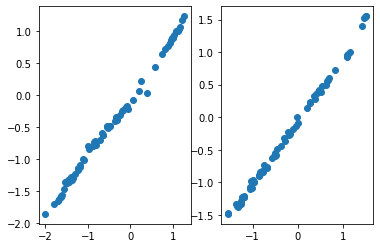

In [120]:
ret = getStats(1, knnprob, True, 0.0)
mydef = ret[0][0]

memdef = fc.defclass()

memdef.load('Files/a2744-def1-scale1')
print(memdef.aarr)

fig, ax = plt.subplots(1, 2)
ax[0].scatter(mydef[:,1], memdef.marr[0,:,1])

ax[1].scatter(mydef[:,0], memdef.marr[0,:,0])


model = np.polyfit(mydef[:,1], memdef.marr[0,:,1], 1)
print(model)

model2 = np.polyfit(mydef[:,0], memdef.marr[0,:,0], 1)
print(model2)

Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0


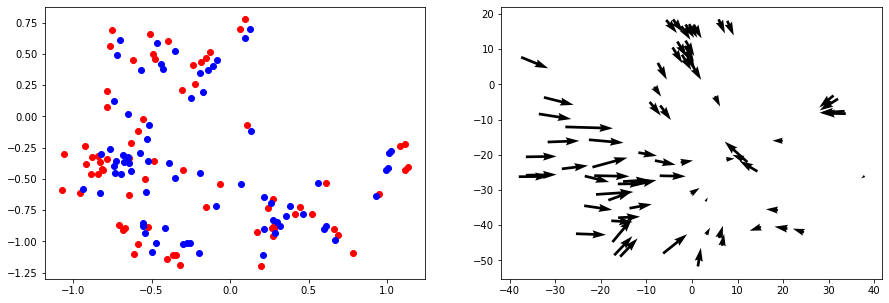

In [79]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))
marr1 = scatterMeans(20, sigmaclass, True, ax1, "red")
marr2 = scatterMeans(20, knnprob, True, ax1, "blue")
diff = marr2 - marr1

ax2.quiver(img.xarr[:,0], img.xarr[:,1], diff[0,:,0], diff[0,:,1])


Read galaxy data from file Files/GalaxyData/a2744-def-sigma.txt
Read galaxy data from file Files/GalaxyData/a2744-def-rnn.txt
Mass scatter: 
X mean: -0.007556320186167374
X std: 0.0738587074704698
Y mean: -0.01384024855939267
Y std: 0.08141175718698872


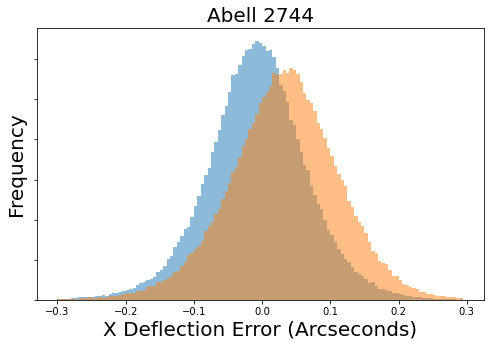

In [14]:
#get overall histograms
def plothist(mode, ax):
    pdelta = []
    gal = fc.galclass("Files/GalaxyData/" + cluster + "-def-" + mode + ".txt", logflags = [True, True])
    gal.scale(b0 = 0.0)
    
    #print(gal.dat)
    
    for i in range(reps):
        gal.draw(True)
        deftmp = gal.calcdef(img)[0]
        deftmp = deftmp*np.reshape(img.Darr,(img.nimg,1))
        
        #print(np.sum(gal.p[:,7]))

        pdelta.append(deftmp - defbase)
        
    pdelta = np.array(pdelta)
    pdeltax = np.reshape(pdelta[:,:,0], (-1))
    pdeltay = np.reshape(pdelta[:,:,1], (-1))

    ax.hist(mdeltax, bins = bins, alpha = 0.5)
    ax.hist(pdeltax, bins = bins, alpha = 0.5)
#     ax2.hist(mdeltay, bins = bins, alpha = 0.5)
#     ax2.hist(pdeltay, bins = bins, alpha = 0.5)
    
#     ax.text(0.8, 0.8, "mean: " + str(np.mean(pdeltax)), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
#     ax.text(0.8, 0.6, "Std: " + str(np.std(pdeltax)), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
    
#     ax2.text(0.8, 0.8, "mean: " + str(np.mean(pdeltay)), horizontalalignment='center', verticalalignment='center', transform = ax2.transAxes)
#     ax2.text(0.8, 0.6, "Std: " + str(np.std(pdeltay)), horizontalalignment='center', verticalalignment='center', transform = ax2.transAxes)



reps = 3000

gal = fc.galclass("Files/GalaxyData/a2744-def-sigma.txt", logflags = [True, True])
gal.scale(b0 = 0.0)
gal.draw(False)

defbase = gal.calcdef(img)[0]
defbase = defbase*np.reshape(img.Darr,(img.nimg,1))

mdelta = []

for i in range(reps):
    gal.draw(True)
    deftmp = gal.calcdef(img)[0]
    deftmp = deftmp*np.reshape(img.Darr,(img.nimg,1))
    
    mdelta.append(deftmp - defbase)
mdelta = np.array(mdelta)

mdeltax = np.reshape(mdelta[:,:,0], (-1))
mdeltay = np.reshape(mdelta[:,:,1], (-1))
bins = np.arange(-0.3, 0.3, 0.005)

fig, ax = plt.subplots(figsize=(8, 5))


plothist("rnn", ax)

#ax2.set_title("R nearest neighbors y error")

ax.set_ylabel("Frequency", fontsize = 20)
ax.set_xlabel("X Deflection Error (Arcseconds)", fontsize = 20)
ax.set_title("Abell 2744", fontsize = 20)
ax.yaxis.set_ticklabels([])

print("Mass scatter: ")
print("X mean: " + str(np.mean(mdeltax)))
print("X std: " + str(np.std(mdeltax)))
print("Y mean: " + str(np.mean(mdeltay)))
print("Y std: " + str(np.std(mdeltay)))

In [54]:
# #Visualize vector field of biases
# xnum = 20
# ynum = 20
# minx = -50
# maxx = 50
# miny = -60
# maxy = 20

# f = open("Files/mock_images_abel.txt", "a")
# f.write("#Mock images\n")
# f.write("1\n2\n3\n4\n5\n1\n" + str((xnum + 1) * (ynum + 1)) + "\n")

# for i in range(ynum + 1):
#     for j in range(xnum + 1):
#         x = minx + j * (maxx - minx) / xnum
#         y = miny + i * (maxy - miny) / ynum
#         f.write(str(x) + " " + str(y) + " 1.0 1.0\n")
        
# f.close()

Read image data from file Files/mock_images_abel.txt
Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500


Text(0.5, 1.0, 'Box differences')

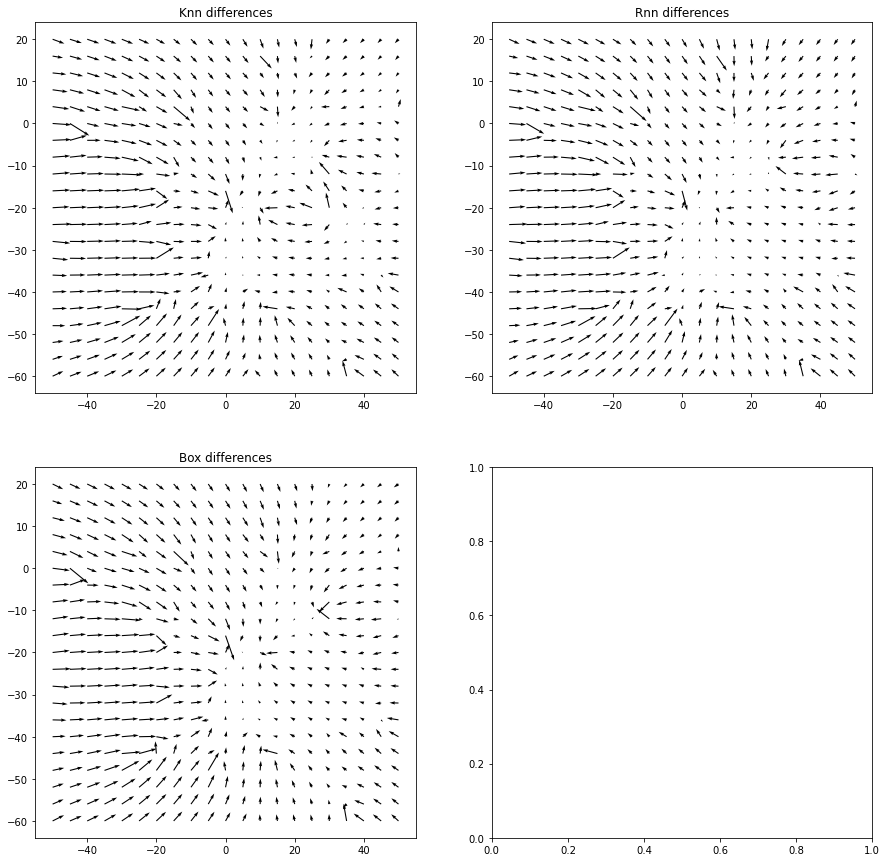

In [55]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
imgmock = fc.imgclass("Files/mock_images_abel.txt", 0.0, cosmo)

marr = getStats(3000, sigmaclass, True, imgmock)[0]
marrk = getStats(3000, knnprob, True, imgmock)[0]
marrr = getStats(3000, rnnprob, True, imgmock)[0]
marrbox = getStats(3000, boxprob, True, imgmock)[0]

diffk = marrk - marr
diffr = marrr - marr
diffbox = marrbox - marr

ax1.quiver(imgmock.xarr[:,0], imgmock.xarr[:,1], diffk[0,:,0], diffk[0,:,1])
ax2.quiver(imgmock.xarr[:,0], imgmock.xarr[:,1], diffr[0,:,0], diffr[0,:,1])
ax3.quiver(imgmock.xarr[:,0], imgmock.xarr[:,1], diffbox[0,:,0], diffbox[0,:,1])

ax1.set_title("Knn differences")
ax2.set_title("Rnn differences")
ax3.set_title("Box differences")

Read image data from file Files/mock_images_full.txt
Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500


Text(0.5, 1.0, 'Box differences')

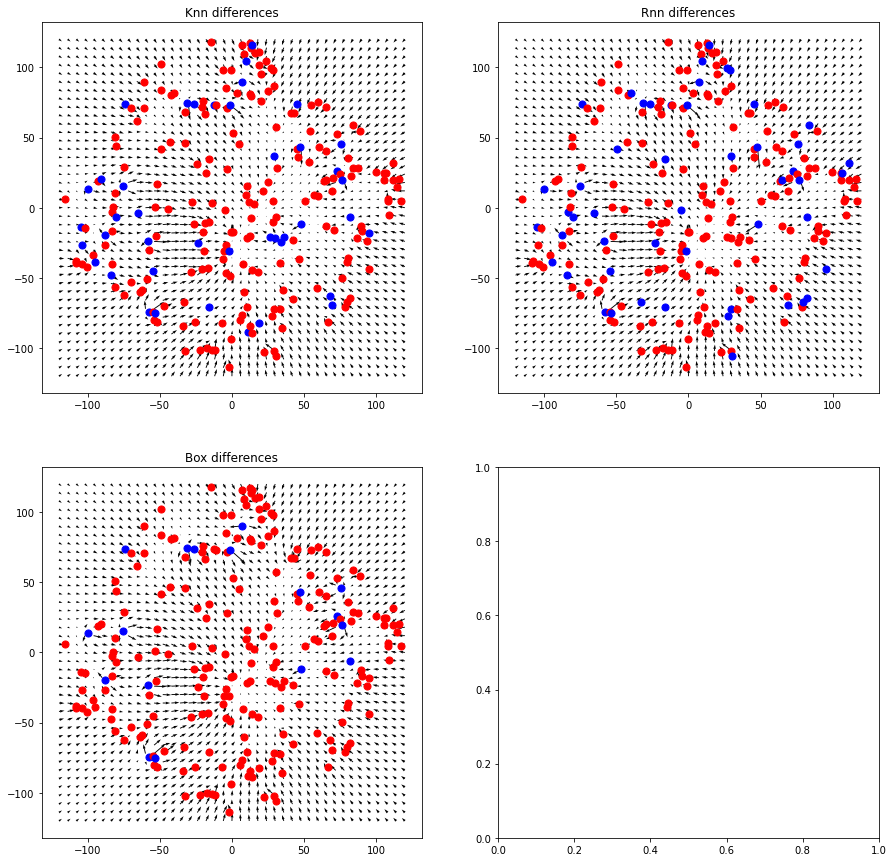

In [56]:
#Create vector field
def plotdiffs(ax, orig, probs):
    for i in range(len(orig)):
        if unknown[i].master_x > -120 and unknown[i].master_x < 120 and unknown[i].master_y > -120 and unknown[i].master_y < 120:
            diff = abs(orig[i] - probs[i])
            if orig[i] < probs[i]:
                ax.scatter(unknown[i].master_x, unknown[i].master_y, color="blue", s = 50)
            else:
                ax.scatter(unknown[i].master_x, unknown[i].master_y, color="red", s = 50)
            
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
imgmock = fc.imgclass("Files/mock_images_full.txt", 0.0, cosmo)

marr = getStats(3000, sigmaclass, True, imgmock)[0]
marrk = getStats(3000, knnprob, True, imgmock)[0]
marrr = getStats(3000, rnnprob, True, imgmock)[0]
marrbox = getStats(3000, boxprob, True, imgmock)[0]

diffk = marrk - marr
diffr = marrr - marr
diffbox = marrbox - marr

ax1.quiver(imgmock.xarr[:,0], imgmock.xarr[:,1], diffk[0,:,0], diffk[0,:,1])
ax2.quiver(imgmock.xarr[:,0], imgmock.xarr[:,1], diffr[0,:,0], diffr[0,:,1])
ax3.quiver(imgmock.xarr[:,0], imgmock.xarr[:,1], diffbox[0,:,0], diffbox[0,:,1])

plotdiffs(ax1, sigmaclass, knnprob)
plotdiffs(ax2, sigmaclass, rnnprob)
plotdiffs(ax3, sigmaclass, boxprob)

ax1.set_title("Knn differences")
ax2.set_title("Rnn differences")
ax3.set_title("Box differences")


Read image data from file Files/mock_images_full.txt


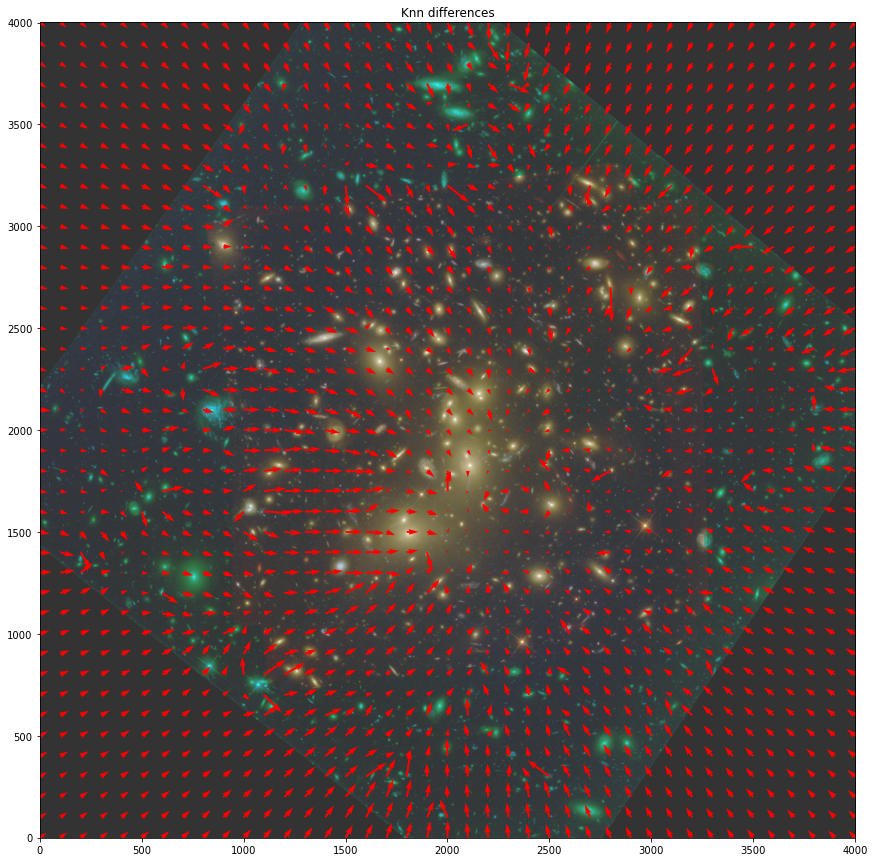

In [57]:
# Plot RGB image
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(imgcut, origin='lower', alpha = 0.8)

imgmock2 = fc.imgclass("Files/mock_images_full.txt", 0.0, cosmo)

ax.quiver(imgmock2.xarr[:,0]/conv + (len(imgcut)/2), imgmock2.xarr[:,1]/conv + (len(imgcut)/2), diffk[0,:,0], diffk[0,:,1], color = "red")

ax.set_title("Knn differences")
#Plot galaxies


plt.show()

In [58]:
print(len(img.xarr))

71


In [59]:
#Comparing 2D gaussians via ellipses
def drawEllipses(probs):
    rownum = 9
    colnum = 8
    fig, axs = plt.subplots(rownum, colnum, figsize = (15, 15))
    marr, garr, Cmar = getStats(3000, sigmaclass, True)
    marr2, garr2, Cmar2 = getStats(3000, probs, True)

    for i, ax in enumerate(fig.axes):
        if i == 71:
            break
        cov = Cmar[0,2 * i : 2*i + 2, 2 * i : 2*i + 2]
        evalue, evector = np.linalg.eig(cov)
        
        if evector[0, 0] < 0:
            evector[:,0] *= -1
            
        angle = np.arcsin(evector[1, 0]) * 180 / np.pi
        ellipse1 = Ellipse(xy = (0, 0), width = 2 * math.sqrt(evalue[0]), height = 2 * math.sqrt(evalue[1]), angle = angle, alpha = 0.7, color = "red")
        
        cov = Cmar2[0,2 * i : 2*i + 2, 2 * i : 2*i + 2]
        evalue, evector = np.linalg.eig(cov)
        
        if evector[0, 0] < 0:
            evector[:,0] *= -1
            
        angle = np.arcsin(evector[1, 0]) * 180 / np.pi
        pos = marr2[0, i] - marr[0, i]
        ellipse2 = Ellipse(xy = pos, width = 2 * math.sqrt(evalue[0]), height = 2 * math.sqrt(evalue[1]), angle = angle, alpha = 0.7, color = "blue")
    
        ax.add_artist(ellipse1)
        ax.add_artist(ellipse2)
        
        ax.set_xlim(-0.2, 0.2)
        ax.set_ylim(-0.2, 0.2)
        
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    
    
    fig.axes[71].axes.xaxis.set_visible(False)
    fig.axes[71].axes.yaxis.set_visible(False)
    plt.show()
        
        


Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500


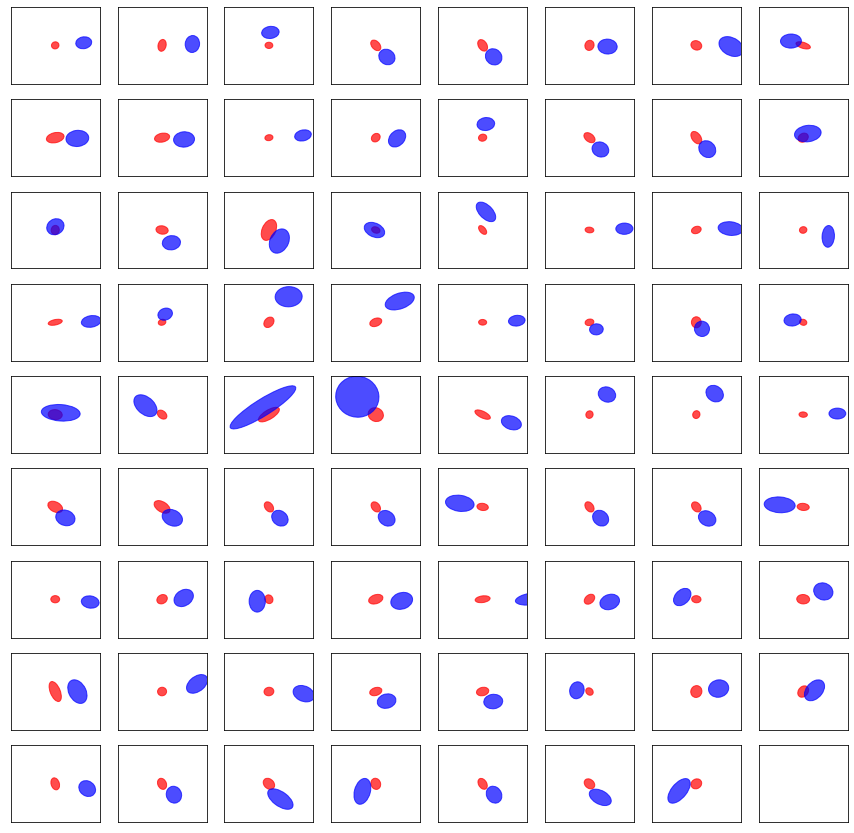

In [60]:
drawEllipses(knnprob)

Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500


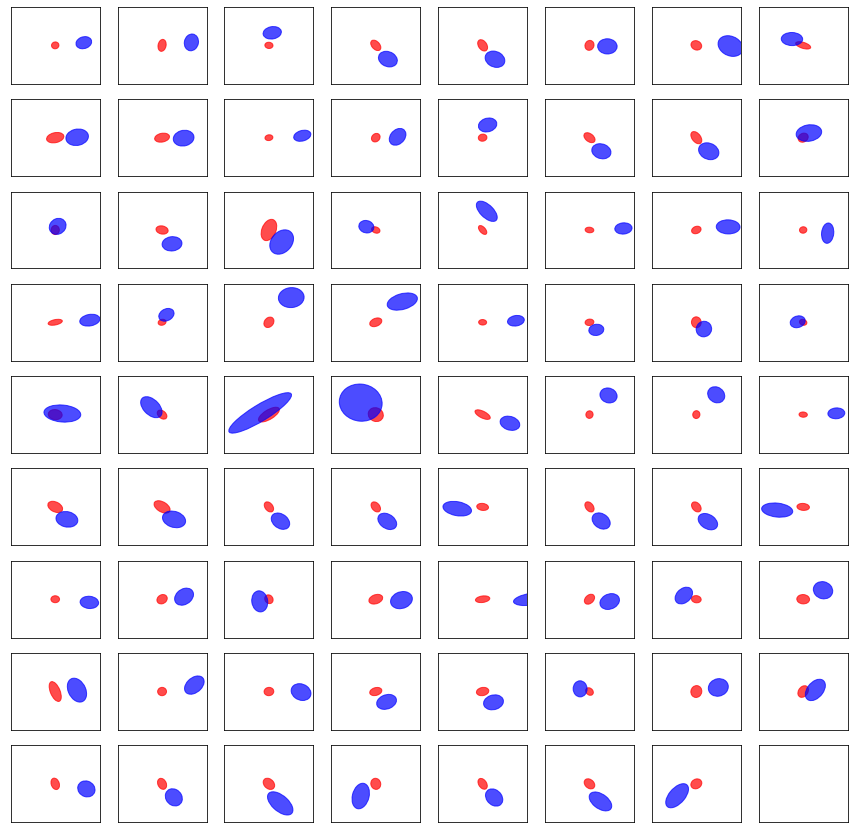

In [61]:
drawEllipses(rnnprob)

Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Read in 327 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500


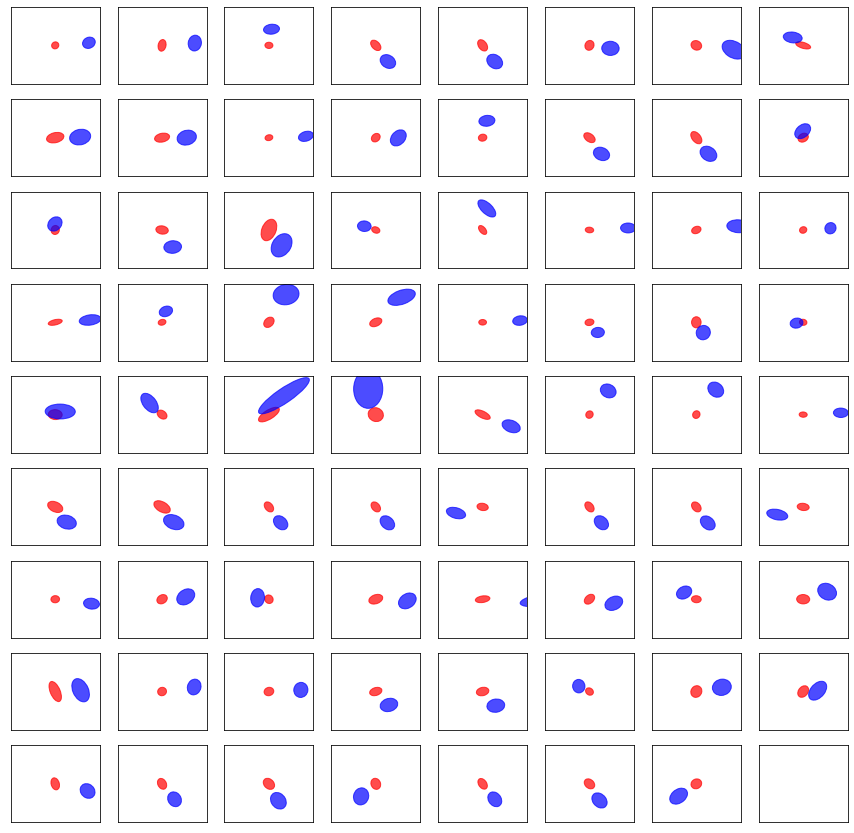

In [62]:
drawEllipses(boxprob)